In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install opencv-contrib-python
!pip install tensorflow-addons
import os
import cv2
import time
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Layer, Input, Conv2D, BatchNormalization, Lambda, Concatenate
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
from tensorflow.keras.layers import (
    Input, SeparableConv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Conv2DTranspose,
    Concatenate, SpatialDropout2D, ReLU, GlobalAveragePooling2D, Add,
    GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda, Activation
)
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import Conv2D, Activation, Add, Multiply, UpSampling2D, Concatenate
from tensorflow.keras.layers import Conv2D, Activation, Add, Multiply, UpSampling2D, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, Concatenate, SpatialDropout2D, ReLU, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda
from tensorflow.keras.initializers import HeNormal

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-qxsqumri
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-qxsqumri
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
working_dir = '/kaggle/working'
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  
            print(f"❌ xóa thành công {item_path}")
    except Exception as e:
        print(f"Lỗi khi xóa {item_path}: {e}")

In [ ]:
def load_isic_dataset(image_path, mask_path, binary_path, csv_file, img_size=(256, 256)):
    image_files = sorted(glob(os.path.join(image_path, "ISIC_*.jpg")))

    images = []
    masks = []
    binary_masks = {}
    image_ids = []
    labels = []

    csv_data = pd.read_csv(csv_file)
    mel_label = csv_data['melanoma'].astype("int64")

    print("Đang đọc và xử lý dữ liệu...")
    for index, img_path in enumerate(tqdm(image_files)):
        img_id = os.path.basename(img_path).split('.')[0]
        mask_file = os.path.join(mask_path, f"{img_id}_segmentation.png")
        binary_file = os.path.join(binary_path, f"{img_id}_features.json")

        if not os.path.exists(mask_file):
            print(f"Không tìm thấy mask cho ảnh mặt nạ {img_id}_segmentation.png")
            continue
        if not os.path.exists(binary_file):
            print(f"Không tìm thấy mask nhị phân cho ảnh {img_id}_features.json")
            continue

        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, img_size)
            mask = cv2.resize(mask, img_size)

            img = img / 255.0
            mask = mask / 255.0

            with open(binary_file, 'r') as f:
                binary_masks[img_id] = json.load(f)
 
            label = mel_label[index]

            images.append(img)
            masks.append(mask)
            image_ids.append(img_id)
            labels.append(label.astype("long"))

        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {img_id}: {str(e)}")
            continue

    images = np.array(images)
    masks = np.array(masks)[..., np.newaxis]  
    labels = np.array(labels)

    print(f"\nĐã đọc thành công {len(images)} ảnh")
    print(f"Shape của images: {images.shape}")
    print(f"Shape của masks: {masks.shape}")
    print(f"Shape của labels: {labels.shape}")

    return images, masks, binary_masks, image_ids, labels

In [44]:
train_images, train_masks, train_binarys, train_image_ids, train_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2750/Train_Data',
    mask_path='/kaggle/input/isic-2750/Train_GroundTruth_1',
    binary_path='/kaggle/input/isic-2750/Train_GroundTruth_2',
    csv_file="/kaggle/input/2075-csv/Train_GroundTruth_3.csv",
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 1925/1925 [04:57<00:00,  6.47it/s]



Đã đọc thành công 1925 ảnh
Shape của images: (1925, 256, 256, 3)
Shape của masks: (1925, 256, 256, 1)
Shape của labels: (1925,)


In [45]:
test_images, test_masks, test_binarys, test_image_ids, test_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2750/Test_Data',
    mask_path='/kaggle/input/isic-2750/Test_GroundTruth_1',
    binary_path='/kaggle/input/isic-2750/Test_GroundTruth_2',
    csv_file='/kaggle/input/2075-csv/Test_GroundTruth_3 (1).csv',
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 825/825 [02:08<00:00,  6.41it/s]



Đã đọc thành công 825 ảnh
Shape của images: (825, 256, 256, 3)
Shape của masks: (825, 256, 256, 1)
Shape của labels: (825,)


In [ ]:
def convert_to_gray_clahe(images_normalized):
    images_clahe = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    for img in images_normalized:

        img_uint8 = np.uint8(img * 255)

        if len(img_uint8.shape) == 3:
            img_gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
        else:
            img_gray = img_uint8  

        img_clahe_uint8 = clahe.apply(img_gray)

        img_clahe = img_clahe_uint8.astype(np.float32) / 255.0

        images_clahe.append(img_clahe)

    return np.array(images_clahe)

train_images_gray_clahe = convert_to_gray_clahe(train_images)
test_images_gray_clahe = convert_to_gray_clahe(test_images)

print(f"Shape ảnh huấn luyện sau CLAHE: {train_images_gray_clahe.shape}")

Shape ảnh huấn luyện sau CLAHE: (1925, 256, 256)


In [ ]:
def compute_metric(y_true, y_pred, metric='dice_coefficient', smooth=1e-6, is_numpy=False):
    y_true_f = y_true.flatten() if is_numpy else K.flatten(y_true)
    y_pred_f = y_pred.flatten() if is_numpy else K.flatten(y_pred)
    intersection = np.sum(y_true_f * y_pred_f) if is_numpy else K.sum(y_true_f * y_pred_f)

    if 'dice' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        score = (2. * intersection + smooth) / (sum_fn(y_true_f) + sum_fn(y_pred_f) + smooth)
    elif 'jaccard' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        union = sum_fn(y_true_f) + sum_fn(y_pred_f) - intersection
        score = (intersection + smooth) / (union + smooth)
    else:
        raise ValueError(f"Unsupported metric: {metric}")

    return score if 'coefficient' in metric else 1 - score

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth)

def jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth)

def jaccard_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_loss', smooth)

def np_accuracy(y_true, y_pred):
    return np.mean(y_true.flatten() == y_pred.flatten())

def np_dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth, is_numpy=True)

def np_jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth, is_numpy=True)

def np_dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth, is_numpy=True)

In [ ]:
def CustomSegUNet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    c1 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(inputs)
    c1 = BatchNormalization()(c1); c1 = ReLU()(c1)
    c1 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c1)
    c1 = BatchNormalization()(c1); c1 = ReLU()(c1)
    c1 = SpatialDropout2D(0.1)(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p1)
    c2 = BatchNormalization()(c2); c2 = ReLU()(c2)
    c2 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c2)
    c2 = BatchNormalization()(c2); c2 = ReLU()(c2)
    c2 = SpatialDropout2D(0.1)(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p2)
    c3 = BatchNormalization()(c3); c3 = ReLU()(c3)
    c3 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c3)
    c3 = BatchNormalization()(c3); c3 = ReLU()(c3)
    c3 = SpatialDropout2D(0.1)(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p3)
    c4 = BatchNormalization()(c4); c4 = ReLU()(c4)
    c4 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c4)
    c4 = BatchNormalization()(c4); c4 = ReLU()(c4)
    c4 = SpatialDropout2D(0.1)(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p4)
    c5 = BatchNormalization()(c5); c5 = ReLU()(c5)
    c5 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c5)
    c5 = BatchNormalization()(c5); c5 = ReLU()(c5)
    c5 = SpatialDropout2D(0.1)(c5)
    p5 = MaxPooling2D((2, 2))(c5)

    c6 = SeparableConv2D(1024, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal(), dilation_rate=(2, 2))(p5)
    c6 = BatchNormalization()(c6)
    c6 = ReLU()(c6)
    c6 = SpatialDropout2D(0.2)(c6)

    u7 = Conv2DTranspose(512, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c6)
    u7 = Concatenate()([u7, c5])
    c7 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u7)
    c7 = BatchNormalization()(c7); c7 = ReLU()(c7)
    c7 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c7)
    c7 = BatchNormalization()(c7); c7 = ReLU()(c7)

    u8 = Conv2DTranspose(256, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c7)
    u8 = Concatenate()([u8, c4])
    c8 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u8)
    c8 = BatchNormalization()(c8); c8 = ReLU()(c8)
    c8 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c8)
    c8 = BatchNormalization()(c8); c8 = ReLU()(c8)

    u9 = Conv2DTranspose(256, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c8)
    u9 = Concatenate()([u9, c3])
    c9 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u9)
    c9 = BatchNormalization()(c9); c9 = ReLU()(c9)
    c9 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c9)
    c9 = BatchNormalization()(c9); c9 = ReLU()(c9)

    u10 = Conv2DTranspose(128, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c9)
    u10 = Concatenate()([u10, c2])
    c10 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u10)
    c10 = BatchNormalization()(c10); c10 = ReLU()(c10)
    c10 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c10)
    c10 = BatchNormalization()(c10); c10 = ReLU()(c10)

    u11 = Conv2DTranspose(64, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c10)
    u11 = Concatenate()([u11, c1])
    c11 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u11)
    c11 = BatchNormalization()(c11); c11 = ReLU()(c11)
    c11 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c11)
    c11 = BatchNormalization()(c11); c11 = ReLU()(c11)
  
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c11)

    return Model(inputs=inputs, outputs=outputs)

if __name__ == "__main__":
    model = CustomSegUNet()
    model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_92       │ (None, 256, 256, 64)   │            137 │ input_layer_4[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_92    │ (None, 256, 256, 64)   │            256 │ separable_conv2d_92[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_92 (ReLU)           │ (None, 256, 256, 64)   │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_93       │ (None, 256, 256, 64)   │          4,736 │ re_lu_92[0][0]         │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_93    │ (None, 256, 256, 64)   │            256 │ separable_conv2d_93[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_93 (ReLU)           │ (None, 256, 256, 64)   │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_24      │ (None, 256, 256, 64)   │              0 │ re_lu_93[0][0]         │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 128, 128, 64)   │              0 │ spatial_dropout2d_24[… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_94       │ (None, 128, 128, 128)  │          8,896 │ max_pooling2d_20[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 128, 128, 128)  │            512 │ separable_conv2d_94[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_94 (ReLU)           │ (None, 128, 128, 128)  │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_95       │ (None, 128, 128, 128)  │         17,664 │ re_lu_94[0][0]         │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 128, 128, 128)  │            512 │ separable_conv2d_95[0… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 9,358,858 (35.70 MB)

 Trainable params: 9,347,082 (35.66 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [51]:
class EarlyStoppingByAccuracyChange(tf.keras.callbacks.Callback):
    def __init__(self, monitor='accuracy', threshold=0.00001, patience=3, verbose=0):
        super(EarlyStoppingByAccuracyChange, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.best_accuracy = -float('inf')
        self.consecutive_stops = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_accuracy = logs.get(self.monitor)
        if current_accuracy is None:
            tf.get_logger().warning(
                'Early stopping requires %s available!', self.monitor
            )
            return

        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.wait = 0
            self.consecutive_stops = 0
        else:
            self.wait += 1
            accuracy_change = current_accuracy - self.best_accuracy
            if abs(accuracy_change) < self.threshold:
                self.consecutive_stops += 1
                if self.consecutive_stops >= self.patience:
                    if self.verbose > 0:
                        print(f"Epoch {epoch+1}: Early stopping triggered due to minimal accuracy change for {self.patience} epochs.")
                    self.model.stop_training = True
            else:
                self.consecutive_stops = 0

In [ ]:
initial_lr = 0.001
optimizer = Adam(learning_rate=initial_lr)

segunet = CustomSegUNet(input_size=(256, 256, 1))
segunet.compile(
    optimizer=optimizer,
    loss=dice_loss,
    metrics=['accuracy', jaccard_coefficient]
)
model_checkpoint_dir = 'model'

checkpoint_path = os.path.join(model_checkpoint_dir, 'cp.ckpt')

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_checkpoint_dir, 'gray2750.weights.h5'),
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStoppingByAccuracyChange(
    monitor='accuracy',
    threshold=0.00001,
    patience=10,
    verbose=1
)
lr_reduction = ReduceLROnPlateau(monitor='loss',
                                  patience=5,
                                  verbose=1,
                                  factor=0.5,
                                  min_lr=0.00001)
start_time = time.time()
history = segunet.fit(
    train_images_gray_clahe, train_masks,
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, lr_reduction, checkpoint_callback]
)

end_time = time.time()
training_time = end_time - start_time

avg_accuracy = np.mean(history.history['accuracy'])
avg_jaccard = np.mean(history.history['jaccard_coefficient'])

print("SegUNet output shape:", segunet.output_shape)
print(f"⏱️ Thời gian huấn luyện: {training_time:.2f} giây")
print(f"✅ Accuracy trung bình: {avg_accuracy*100:.2f}%")
print(f"🔗 Jaccard trung bình: {avg_jaccard*100:.2f}%")

Epoch 1/100
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.7969 - jaccard_coefficient: 0.3881 - loss: 0.4590

E0000 00:00:1761397822.287663     189 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761397822.521457     189 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761397823.635266     189 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761397823.869024     189 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 978ms/step - accuracy: 0.7980 - jaccard_coefficient: 0.3901 - loss: 0.4570
Epoch 1: loss improved from inf to 0.33789, saving model to model/gray2750.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 102s 988ms/step - accuracy: 0.7991 - jaccard_coefficient: 0.3921 - loss: 0.4551 - learning_rate: 0.0010
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.9184 - jaccard_coefficient: 0.6385 - loss: 0.2221
Epoch 2: loss improved from 0.33789 to 0.21021, saving model to model/gray2750.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 671ms/step - accuracy: 0.9185 - jaccard_coefficient: 0.6388 - loss: 0.2219 - learning_rate: 0.0010
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.9358 - jaccard_coefficient: 0.7052 - loss: 0.1735
Epoch 3: loss improved from 0.21021 to 0.17522, saving model to model/gray2750.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 671ms/step - accuracy: 0.9358 - jaccard_coefficient: 0.7051 - loss: 0.1735 - learning_rate: 0.0010
Epoc

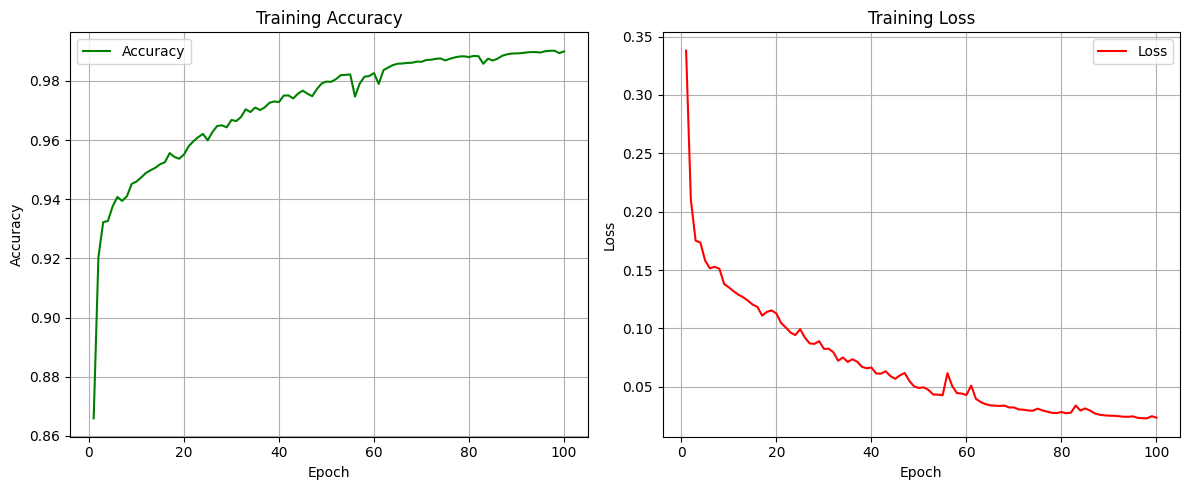

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('Gray_2750_acc_loss.png', dpi=300)
plt.show()


In [ ]:
def apply_morphology(mask, kernel_size=3, iterations=1):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask = (mask > 0.5).astype(np.uint8) 

    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=iterations)

    return opened.astype(np.float32)  

print("🔍 Đánh giá không hậu xử lý...")
results = segunet.evaluate(test_images_gray_clahe, test_masks, verbose=1)
loss, accuracy, jaccard = results
print(f"Không hậu xử lý - Dice Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%, Jaccard: {jaccard*100:.2f}%")

print("\n🔧 Đánh giá sau Morphology...")
predictions1 = segunet.predict(test_images_gray_clahe)
refined_predictions1 = []

for i in tqdm(range(len(test_images_gray_clahe))):
    pred = predictions1[i].squeeze()

    morph_pred = apply_morphology(pred, kernel_size=7, iterations=2)

    refined_predictions1.append(morph_pred)

refined_predictions1 = np.expand_dims(np.array(refined_predictions1), axis=-1)

accuracy_after = np_accuracy(test_masks, refined_predictions1)
jaccard_after = np_jaccard_coefficient(test_masks, refined_predictions1)
loss_after = np_dice_loss(test_masks, refined_predictions1)

print(f"Sau Morphology - Dice Loss: {loss_after:.4f}, Accuracy: {accuracy_after*100:.2f}%, Jaccard: {jaccard_after*100:.2f}%")

🔍 Đánh giá không hậu xử lý...
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.9526 - jaccard_coefficient: 0.7944 - loss: 0.1172
Không hậu xử lý - Dice Loss: 0.1517, Accuracy: 94.83%, Jaccard: 74.29%

🔧 Đánh giá sau Morphology...
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step


100%|██████████| 825/825 [00:00<00:00, 1707.05it/s]


Sau Morphology - Dice Loss: 0.1353, Accuracy: 94.83%, Jaccard: 76.17%


In [66]:
segunet.save('/kaggle/working/model/2.0-gray_2750_model.h5')
segunet.save('/kaggle/working/model/2.0-gray_2750_model.keras')